# Encoding EEG Signals using Deep Learning 


In this work, We use Auto-enocoder model to encode our high dimensional input data into a smaller feature vector. Autoencoders are type of neural network that can learn to represent  the higher dimensional data into lower-dimensional representation by projecting the data into latent space [1]. Latent space is the low dimensional manifold of high dimensional images where all the instances of the dataset lie in proximity. The auto-encoder is composed of an encoder and a decoder part. The encoder takes in an input and projects it to a lower-dimensional representaion space while the decoder takes the lower dimensional representation and maps it back to the original input. The training objective is to minimize the difference between the input and the reconstructed output. While minimizing the objective function, the autoencoders learns to identify the most important features of the input data in the lower-dimensional representation space. 

The objective of this work is to identify important features from the Electroencephalography (EEG) data. EEG captures electrical activity in brain using multiple electrodes attached to the scalp [2]. The volatge fluctuations in the EEG represents underlying brain activites which can be used to identify normal or abnormal functioning of the brain [3]. 



# Implementation:

 The autoencoder model was implemented using pytorch framework. The model was trained on A100- Nvidia GPU at ex3 clusters. Electroencephalography (EEG) dataset is used to train the model. 

 ## Data:

The TUH Abnormal EEG dataset is used to train the autoencoder model. The task is to classify the raw EEG recordings into normal or abnormal class. The data is open source and includes 2993 EEG recordings of at least 15 mins time duration [4]. The dataset is divided into training and validation set. The training set contains of 2717 recordings(1371 normal class and 1346 abnormal class) and validation set holds 276 recordings(150 normal normal and 120 abnormal class). 

 ## Data Preprocessing:
 Some minimal pre-processing is applied to the raw EEG data. A subset of common 19 electrodes are selected for all the recordings. The EEG signals were downsampled to 100 HZ and clipped at ±800µV to avoid extreme outliers.The band pass filtering is applided from 0 to 40 HZ . Then, the EEG recordings are split by using sliding window method so that each recordings has the shape of "#of window samples x channle x time " . The choice of size of sliding window is determined by the sampling frequency so that it includes most of the important frequencies. 


# Model:

The autoencoder consists of the encoder and decoder part. The encoder part is implemented by using convolutional network where the image is scale down layere by layer using strided convoltuios . The image is downscaled three times. Then , the downscaled image is flattened and linear layer is applied . The latent representation is obtained as a vector of size 128.  Then, the decoder part takes the vector of size 128 and scales up using transposed convlution layers. The transposed convolution adds stride to the input insetead of the output and scales up the input. The final layer of the decoder reconstructs the original image. 

The loss function for training the auto-enocder model is the mean squared error (MSE). The MSE is avearged over the batch dimension while training the model. The Adam optimizer [5] has been adopted to optimize the loss function. 

The implemenation of the model and  training is illustrated below in the $ ´Model´ $ section of the notebook.




 # Referneces :

1. Kramer, Mark A. (1991). "Nonlinear principal component analysis using autoassociative neural networks" (PDF). AIChE Journal. 37 (2): 233–243. doi:10.1002/aic.690370209.

2. Amzica, Florin; Lopes da Silva, Fernando H. (November 2017). Schomer, Donald L.; Lopes da Silva, Fernando H. (eds.). Cellular Substrates of Brain Rhythms. Vol. 1. Oxford University Press. doi:10.1093/med/9780190228484.003.0002

3. Principles of neural science. Eric R. Kandel, John Koester, Sarah Mack, Steven Siegelbaum (6th ed.). New York. 2021. p. 1450. ISBN 978-1-259-64223-4. OCLC 1199587061

4. TUH Abnormal EEG Corpus. https://www.isip.piconepress.com/projects/tuh_eeg/html/downloads.shtml

5. A. Agnes Lydia and , F. Sagayaraj Francis, Adagrad - An Optimizer for Stochastic Gradient Descent, Department of Computer Science and Engineering, Pondicherry Engineering College, May 2019.



# Model 

In [6]:
## Standard libraries
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
#%matplotlib inline
#from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgb
import matplotlib
#matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from PIL import Image

# Torchvision
import torchvision
from torchvision import transforms
from torchvision.datasets.vision import VisionDataset


# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Path to the  data folder 
TRAIN_DIR = "/home/rabink1/D1/vtf_images/tuh/train"
VAL_DIR = "/home/rabink1/D1/vtf_images/tuh/eval"

# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/"

# Setting the seed
pl.seed_everything(42)


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

TypeError: Couldn't build proto file into descriptor pool!
Invalid proto descriptor for file "tensorboard/compat/proto/tensor_shape.proto":
  tensorboard.TensorShapeProto.dim: "tensorboard.TensorShapeProto.dim" is already defined in file "tensorboard/src/tensor_shape.proto".
  tensorboard.TensorShapeProto.unknown_rank: "tensorboard.TensorShapeProto.unknown_rank" is already defined in file "tensorboard/src/tensor_shape.proto".
  tensorboard.TensorShapeProto.Dim.size: "tensorboard.TensorShapeProto.Dim.size" is already defined in file "tensorboard/src/tensor_shape.proto".
  tensorboard.TensorShapeProto.Dim.name: "tensorboard.TensorShapeProto.Dim.name" is already defined in file "tensorboard/src/tensor_shape.proto".
  tensorboard.TensorShapeProto.Dim: "tensorboard.TensorShapeProto.Dim" is already defined in file "tensorboard/src/tensor_shape.proto".
  tensorboard.TensorShapeProto: "tensorboard.TensorShapeProto" is already defined in file "tensorboard/src/tensor_shape.proto".
  tensorboard.TensorShapeProto.dim: "tensorboard.TensorShapeProto.Dim" seems to be defined in "tensorboard/src/tensor_shape.proto", which is not imported by "tensorboard/compat/proto/tensor_shape.proto".  To use it here, please add the necessary import.


In [2]:
# Dataloader

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp', '.npy')

def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.
    Args:
        filename (string): path to a file
        extensions (tuple of strings): extensions to consider (lowercase)
    Returns:
        bool: True if the filename ends with one of given extensions
    """
    return filename.lower().endswith(extensions)


def make_dataset(directory, class_to_idx, extensions=None, is_valid_file=None):
    instances = []
    directory = os.path.expanduser(directory)
    both_none = extensions is None and is_valid_file is None
    both_something = extensions is not None and is_valid_file is not None
    if both_none or both_something:
        raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")
    if extensions is not None:
        def is_valid_file(x):
            return has_file_allowed_extension(x, extensions)
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(directory, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_valid_file(path):
                    item = path, class_index
                    instances.append(item)
    return instances



class DatasetFolder(VisionDataset):
    def __init__(self, root, loader, extensions=None, transform=None,
                 target_transform=None, is_valid_file=None):
        super(DatasetFolder, self).__init__(root, transform=transform,
                                            target_transform=target_transform)
        classes, class_to_idx = self._find_classes(self.root)
        samples = make_dataset(self.root, class_to_idx, extensions, is_valid_file)
        if len(samples) == 0:
            raise (RuntimeError(
                "Found 0 files in subfolders of: " + self.root + "\nSupported extensions are: " + ",".join(extensions)))

        self.loader = loader
        self.extensions = extensions

        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]

    def _find_classes(self, dir):
        """
        Finds the class folders in a dataset.
        Args:
            dir (string): Root directory path.
        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (dir), and class_to_idx is a dictionary.
        Ensures:
            No class is a subdirectory of another.
        """
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self):
        return len(self.samples)
    

def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def npy_loader(path):
    img = np.load(path).astype("float32") 
    # img=resize(img,(1,30,337500))
    #img=np.array(Image.fromarray((img * 255).astype(np.uint8)))
    img=torch.from_numpy(img)
    return img


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)



class ImageFolder(DatasetFolder):
    def __init__(self, root, transform=None, target_transform=None,
                 loader=npy_loader, is_valid_file=None):
        super(ImageFolder, self).__init__(root, loader, IMG_EXTENSIONS if is_valid_file is None else None,
                                          transform=transform,
                                          target_transform=target_transform,
                                          is_valid_file=is_valid_file)
        self.imgs = self.samples







# Model

In [3]:

class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For EEG, this parameter is 118
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 19x500 => 10x250
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 10x16 => 5x125
             act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 5x125 => 3x63
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(3*63*128, latent_dim)

        )

    def forward(self, x):
        return self.net(x)

In [4]:
class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For EEG, this parameter is 118
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*3*63*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=0, padding=1, stride=2), # 3x63 => 5x125
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 5x125=> 10x250
            act_fn(),

            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=(0,1), padding=1, stride=2), # 5 x125 => 19x500
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well

        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 3, 63)
        x = self.net(x)
        return x

In [5]:
def normalise(x):
    norm=(2*x - x.max()- x.min())/(x.max() - x.min())
    return norm 

def norm_unit8(image):
    image /= image.max()/255.0 
    return image

train_transforms = transforms.Compose([
        #transforms.ToTensor(),
        transforms.Lambda(normalise)
        #transforms.Lambda(norm_unit8)
    ])
val_transforms = transforms.Compose([
       #transforms.ToTensor(),
        transforms.Lambda(normalise)
        #transforms.Lambda(norm_unit8)

    ])

train_dataset = ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = ImageFolder(VAL_DIR, transform=val_transforms)

train_loader = DataLoader(train_dataset,
                              batch_size=32,
                              shuffle=False,
                              num_workers=4,
                              # pin_memory=True if device else False
                              )
val_loader = DataLoader(val_dataset,
                            batch_size=32,
                            shuffle=False,
                            num_workers=4,
                            # pin_memory=True if device else False
                            )

def get_train_subjects(num):
    return torch.stack([train_dataset[i][0] for  i in range(num)], dim=0)

In [6]:
class Autoencoder(pl.LightningModule):

    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 118,
                 width: int = 500,
                 height: int = 19):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)

    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x, _ = batch # We do not need the labels
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode='min',
                                                         factor=0.2,
                                                         patience=20,
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)

In [7]:
class GenerateCallback(pl.Callback):

    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs # Images to reconstruct during training
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
            # Plot and add to tensorboard
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, range=(-1,1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)

In [8]:
def train_eeg(latent_dim):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, f"EEG_{latent_dim}"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=500,
                         callbacks=[ModelCheckpoint(save_weights_only=True),
                                   # GenerateCallback(get_train_subjects(8), every_n_epochs=10),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"EEG_{latent_dim}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = Autoencoder.load_from_checkpoint(pretrained_filename)
    else:
        model = Autoencoder(base_channel_size=64, latent_dim=latent_dim)
        trainer.fit(model, train_loader, val_loader)
    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    #test_result = trainer.test(model, test_loader, verbose=False)
    #result = {"test": test_result, "val": val_result}
    result = {"val": val_result}
    return model, result

In [ ]:
model_dict = {}
for latent_dim in [64, 128, 256]:
    model_ld, result_ld = train_eeg(latent_dim)
    model_dict[latent_dim] = {"model": model_ld, "result": result_ld}

In [9]:
# Load the saved model 

model=Autoencoder(base_channel_size=64, latent_dim=128)
checkpoint=torch.load("/home/rabink1/EEG_Encoder/saved_models/EEG_128/lightning_logs/version_445832/checkpoints/epoch=499-step=42500.ckpt")
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [11]:
window_number = 50
num_of_subjects= 2
choose_subject=0 # ranges from 0 to num_of_subjects
input_subjects=get_train_subjects(num_of_subjects)
input_imgs=input_subjects[choose_subject][window_number]
input_subjects.shape,input_imgs.shape


(torch.Size([2, 118, 19, 500]), torch.Size([19, 500]))

In [31]:

#def visualize_reconstructions(model, input_subjects):
    # Reconstruct images
model.eval()
with torch.no_grad():
    reconst_imgs = model(input_subjects.to(model.device))
reconst_imgs = reconst_imgs.cpu()
print(reconst_imgs.shape)

# Plotting
imgs = torch.stack([input_subjects, reconst_imgs], dim=1).flatten(0,1)

print(imgs.shape)
imgs[:,0,:,:].unsqueeze(1).shape

torch.Size([2, 118, 19, 500])
torch.Size([4, 118, 19, 500])


torch.Size([4, 1, 19, 500])

torch.Size([86, 504, 3])


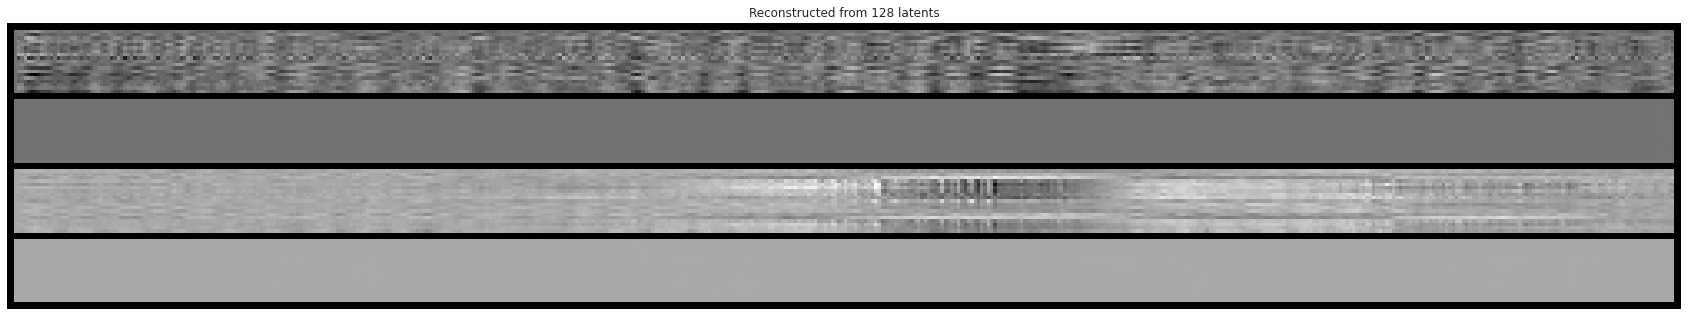

In [33]:
grid = torchvision.utils.make_grid(imgs[:,0,:,:].unsqueeze(1), nrow=1, normalize=True, range=(-1,1))

grid = grid.permute(1, 2, 0)
print(grid.shape)

plt.figure(figsize=(30,30))
plt.title(f"Reconstructed from {model.hparams.latent_dim} latents")
plt.imshow(grid,cmap="viridis")
plt.axis('off')
plt.show()


In [34]:
#Finding similar subjects

def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    for imgs, _ in tqdm(data_loader, desc="Encoding images", leave=False):
        with torch.no_grad():
            z = model.encoder(imgs.to(model.device))
        img_list.append(imgs)
        embed_list.append(z)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0))

train_img_embeds = embed_imgs(model, train_loader)


Encoding images:   0%|          | 0/85 [00:00<?, ?it/s]

In [35]:
test_img_embeds = embed_imgs(model, val_loader)

Encoding images:   0%|          | 0/9 [00:00<?, ?it/s]

In [105]:
test_img_embeds[1][:276].shape
val_dataset[2][1]
test_img_embeds[0][:276][:,50,:,:].unsqueeze(1).shape

torch.Size([276, 1, 19, 500])

In [79]:
# Create a summary writer
writer = SummaryWriter("tensorboard/")

In [106]:
NUM_IMGS = len( val_dataset)

writer.add_embedding(test_img_embeds[1][:NUM_IMGS], # Encodings per image
                     metadata=[val_dataset[i][1] for i in range(NUM_IMGS)], # Adding the labels per image to the plot
                     label_img=(test_img_embeds[0][:NUM_IMGS][:,50,:,:].unsqueeze(1)+1)/2.0) # Adding the original images to the plot

In [5]:
%tensorboard --logdir tensorboard/


UsageError: Line magic function `%tensorboard` not found.
